# Resnet + transfer learning
Instead of training from scratch, we can use a pretrained model, like ResNet18 or ResNet34, with:
- frozen early layers
- fine-tuned later layers
Transfer learning can help achieve better performance and reduce training time, as the model has already learned useful features from the large dataset.

First, we will use a ResNet18 model from torchvision.models. The model will be pretrained on the ImageNet dataset, a large dataset with millions of images of many different classes. The final layer of the ResNet18 model is modified to match the binary output for our Pneumonia classification. Then we will repeat training with a ResNet34 model and see which one performs best.

## Import required libraries


In [1]:
import os
import sys
import torch
from torchinfo import summary
module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_train_transforms, get_val_transforms
from src.models import resnet
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate

## Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 1e-3 # good starting point for fine-tuning pretrained models
img_size = 224 #
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


## Load data
The training data is augmented to improve performance and the dataset is balanced through resampling.

In [3]:
# augment and balance the data

train_transform = get_train_transforms(img_size,augment=True)
val_transform = get_val_transforms(img_size)
# set num_workers to 0, safer on Windows with CPU
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## 1. Resnet18 model (freeze layers)
Use a pre-trained Resnet18 model and freeze all layers except the final classification head. This reduces the risk of overfitting. After a few epocs we could fine-tune te model further by unfreezing some of te deeper layers, and continque training at a lower learning rage.
### Model setup

In [ ]:
model_resnet18_freeze = resnet.get_resnet18(pretrained=True, grayscale=True, freeze= True).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()


head_params = [
    {'params': model_resnet18_freeze.conv1.parameters(),'lr':learning_rate},
    {'params': model_resnet18_freeze.fc.parameters(),'lr': learning_rate}
    ]
#optimizer with weightdecay
# use AdamW optimizer as it decouples weight decay from gradient update, leading to more consistent regularization and better generalization than the Adam optimizer
optimizer = torch.optim.AdamW(head_params, weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# print the model summary
summary(model_resnet18_freeze,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]      

### Train the model: warm-up/ head-only stage

In [5]:
# train for 10 epochs
metrics_history_rn18_freeze = train_model(model_resnet18_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [09:10<00:00,  3.38s/it]


  Average train loss:0.387600  
 Accuracy on the train dataset: 84.82%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


  Average val loss:0.480768  
 Accuracy on the validation dataset: 78.37%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [08:09<00:00,  3.00s/it]


  Average train loss:0.243415  
 Accuracy on the train dataset: 90.99%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


  Average val loss:0.414638  
 Accuracy on the validation dataset: 81.57%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:37<00:00,  2.81s/it]


  Average train loss:0.221185  
 Accuracy on the train dataset: 91.60%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


  Average val loss:0.394831  
 Accuracy on the validation dataset: 82.85%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:46<00:00,  2.86s/it]


  Average train loss:0.207831  
 Accuracy on the train dataset: 91.66%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


  Average val loss:0.393315  
 Accuracy on the validation dataset: 82.85%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:32<00:00,  2.78s/it]


  Average train loss:0.195292  
 Accuracy on the train dataset: 92.77%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.385226  
 Accuracy on the validation dataset: 83.17%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:22<00:00,  2.71s/it]


  Average train loss:0.185467  
 Accuracy on the train dataset: 92.87%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.355812  
 Accuracy on the validation dataset: 84.62%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:19<00:00,  2.70s/it]


  Average train loss:0.182371  
 Accuracy on the train dataset: 92.75%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.356350  
 Accuracy on the validation dataset: 85.26%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:18<00:00,  2.69s/it]


  Average train loss:0.173010  
 Accuracy on the train dataset: 93.54%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.303611  
 Accuracy on the validation dataset: 87.66%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:22<00:00,  2.72s/it]


  Average train loss:0.161049  
 Accuracy on the train dataset: 94.17%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.302442  
 Accuracy on the validation dataset: 87.82%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [07:16<00:00,  2.68s/it]


  Average train loss:0.168102  
 Accuracy on the train dataset: 93.77%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]

  Average val loss:0.305971  
 Accuracy on the validation dataset: 87.34%
Done!


### Train the model: Fine-tuning
Unfreeze a deeper layer (layer4) to fine-tune the model, and train again for a number of epochs


In [7]:
# unfreeze the layer 
for name, param in model_resnet18_freeze.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    
# Re-build the optimizer with different LRs
finetune_params = [
    {'params':model_resnet18_freeze.conv1.parameters(), 'lr':learning_rate*0.1}, # keep learning, but slower
    {'params':model_resnet18_freeze.layer4.parameters(), 'lr':learning_rate*0.01},# even slower
    {'params': model_resnet18_freeze.fc.parameters(),'lr':learning_rate*0.1}
]

optimizer = torch.optim.AdamW(finetune_params, weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


metrics_history_rn18_finetuned = train_model(model_resnet18_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [09:55<00:00,  3.65s/it]


  Average train loss:0.154931  
 Accuracy on the train dataset: 94.27%


Validation: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


  Average val loss:0.273528  
 Accuracy on the validation dataset: 88.78%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [07:41<00:00,  2.83s/it]


  Average train loss:0.118320  
 Accuracy on the train dataset: 95.51%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


  Average val loss:0.263542  
 Accuracy on the validation dataset: 89.10%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [07:36<00:00,  2.80s/it]


  Average train loss:0.108424  
 Accuracy on the train dataset: 96.24%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


  Average val loss:0.286197  
 Accuracy on the validation dataset: 89.58%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [07:35<00:00,  2.79s/it]


  Average train loss:0.097782  
 Accuracy on the train dataset: 96.17%


Validation: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


  Average val loss:0.253582  
 Accuracy on the validation dataset: 89.10%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [07:41<00:00,  2.83s/it]


  Average train loss:0.088179  
 Accuracy on the train dataset: 96.66%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.239674  
 Accuracy on the validation dataset: 90.54%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [07:21<00:00,  2.71s/it]


  Average train loss:0.085965  
 Accuracy on the train dataset: 96.80%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.242757  
 Accuracy on the validation dataset: 89.90%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [07:57<00:00,  2.93s/it]


  Average train loss:0.086662  
 Accuracy on the train dataset: 96.99%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


  Average val loss:0.232300  
 Accuracy on the validation dataset: 90.38%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [07:31<00:00,  2.77s/it]


  Average train loss:0.076654  
 Accuracy on the train dataset: 97.55%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.254605  
 Accuracy on the validation dataset: 90.54%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [07:58<00:00,  2.94s/it]


  Average train loss:0.076507  
 Accuracy on the train dataset: 97.37%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


  Average val loss:0.252301  
 Accuracy on the validation dataset: 90.06%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [08:10<00:00,  3.01s/it]


  Average train loss:0.069469  
 Accuracy on the train dataset: 97.41%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

  Average val loss:0.272420  
 Accuracy on the validation dataset: 89.42%
Done!


### Save the model

In [8]:
torch.save(model_resnet18_freeze,'../models/resnet18_freeze_10ep_finetuned_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:37<00:00,  1.85s/it]


Accuracy on the test set: 89.42%
Precision: 0.88, Recall: 0.97, F1 score: 0.92, AUC: 0.87
classification_report :              precision    recall  f1-score   support

           0       0.94      0.77      0.85       234
           1       0.88      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



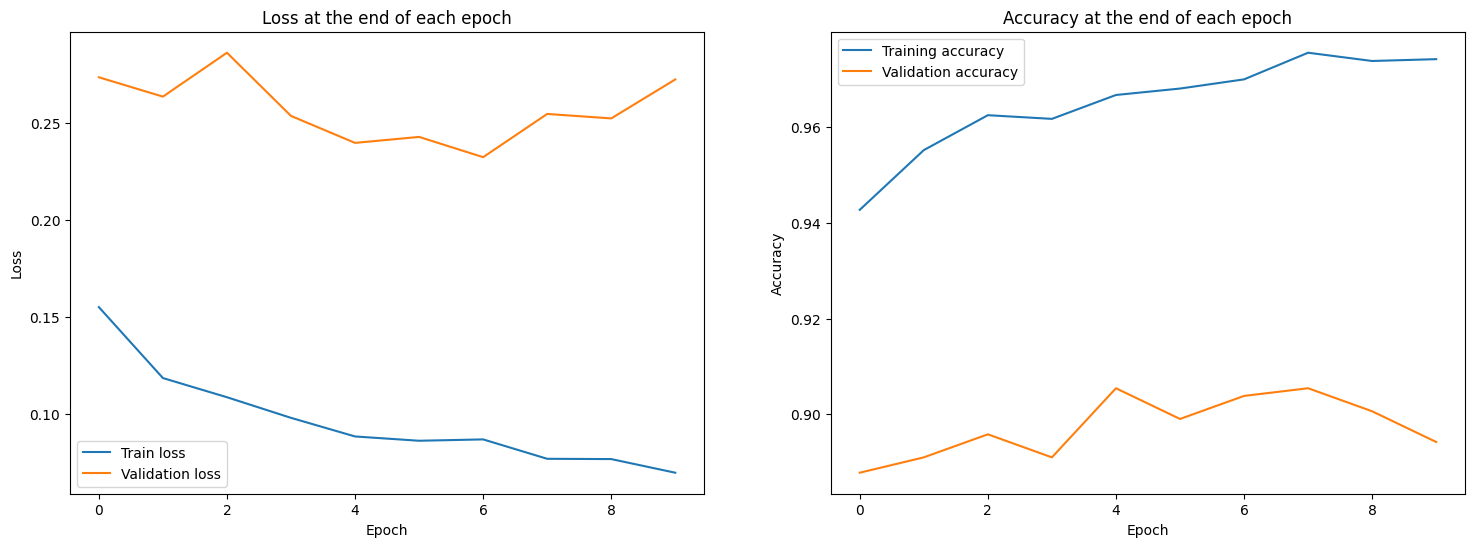

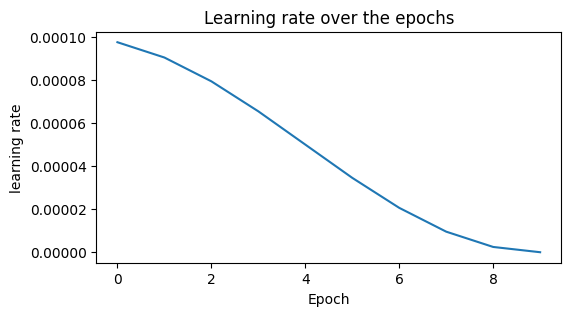

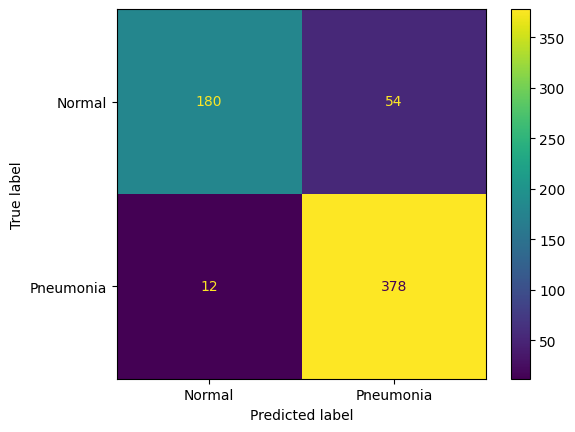

In [9]:
plot_learningcurve(metrics_history_rn18_finetuned)

plot_learningrate(metrics_history_rn18_finetuned['lrs'])

eval_metrics_rn18_finetuned = evaluate_model(model_resnet18_freeze, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn18_finetuned['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn18_finetuned['precision']:.2f}, Recall: {eval_metrics_rn18_finetuned['recall']:.2f}, F1 score: {eval_metrics_rn18_finetuned['f1']:.2f}, AUC: {eval_metrics_rn18_finetuned['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn18_finetuned['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn18_finetuned['confusion matrix'])

## 2 ResNet18 model (no freezing, all layers trainable)
let's also try to start with a pretrained ResNet18 model but allow all layers to be trainable. The model has already learned from millions of images in ImageNet dataset, and learned generic features like edges, textures and shapes. Therefore, it converges faster and requires fewer epochs and less data to reach high accuracy.
### Model setup

In [10]:
learning_rate = 1e-4 # good starting point for fine-tuning pretrained models

model_resnet18_full = resnet.get_resnet18(pretrained=True, grayscale=True, freeze= False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weightdecay
optimizer = torch.optim.AdamW(model_resnet18_full.parameters(), lr=learning_rate,weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# print the model summary
summary(model_resnet18_full,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

### Train the model


In [11]:
metrics_history_rn18_full = train_model(model_resnet18_full,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [09:07<00:00,  3.36s/it]


  Average train loss:0.134699  
 Accuracy on the train dataset: 94.80%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


  Average val loss:0.227201  
 Accuracy on the validation dataset: 90.38%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [09:03<00:00,  3.34s/it]


  Average train loss:0.089806  
 Accuracy on the train dataset: 96.61%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


  Average val loss:0.361816  
 Accuracy on the validation dataset: 86.70%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [08:38<00:00,  3.18s/it]


  Average train loss:0.069209  
 Accuracy on the train dataset: 97.64%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


  Average val loss:0.299491  
 Accuracy on the validation dataset: 89.10%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [08:28<00:00,  3.12s/it]


  Average train loss:0.054886  
 Accuracy on the train dataset: 98.31%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.251081  
 Accuracy on the validation dataset: 90.22%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [08:24<00:00,  3.10s/it]


  Average train loss:0.039365  
 Accuracy on the train dataset: 98.73%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


  Average val loss:0.369511  
 Accuracy on the validation dataset: 88.46%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [08:23<00:00,  3.09s/it]


  Average train loss:0.034000  
 Accuracy on the train dataset: 98.79%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


  Average val loss:0.324177  
 Accuracy on the validation dataset: 90.38%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [08:25<00:00,  3.10s/it]


  Average train loss:0.018323  
 Accuracy on the train dataset: 99.37%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.256042  
 Accuracy on the validation dataset: 91.03%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [08:44<00:00,  3.22s/it]


  Average train loss:0.020459  
 Accuracy on the train dataset: 99.37%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


  Average val loss:0.245454  
 Accuracy on the validation dataset: 91.51%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [08:39<00:00,  3.18s/it]


  Average train loss:0.019007  
 Accuracy on the train dataset: 99.41%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.317388  
 Accuracy on the validation dataset: 90.06%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [08:37<00:00,  3.17s/it]


  Average train loss:0.018653  
 Accuracy on the train dataset: 99.29%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

  Average val loss:0.250953  
 Accuracy on the validation dataset: 91.83%
Done!


### Save the model

In [12]:
torch.save(model_resnet18_full,'../models/resnet18_pretrained_trainable_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Accuracy on the test set: 91.83%
Precision: 0.90, Recall: 0.98, F1 score: 0.94, AUC: 0.90
classification_report :              precision    recall  f1-score   support

           0       0.96      0.82      0.88       234
           1       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



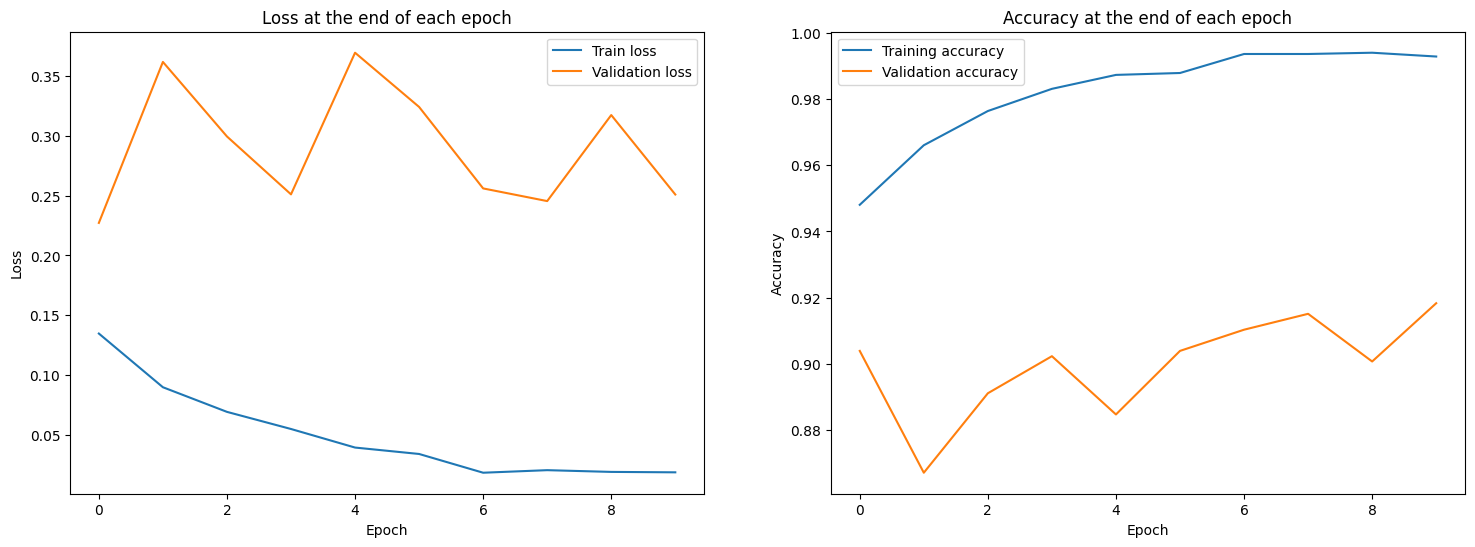

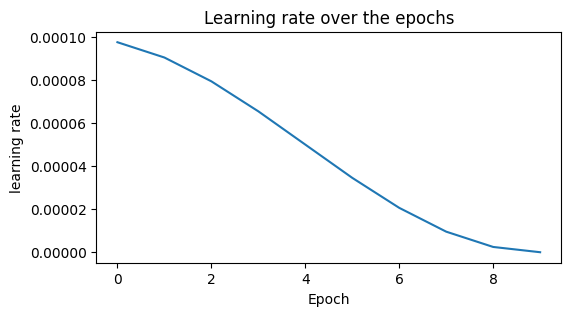

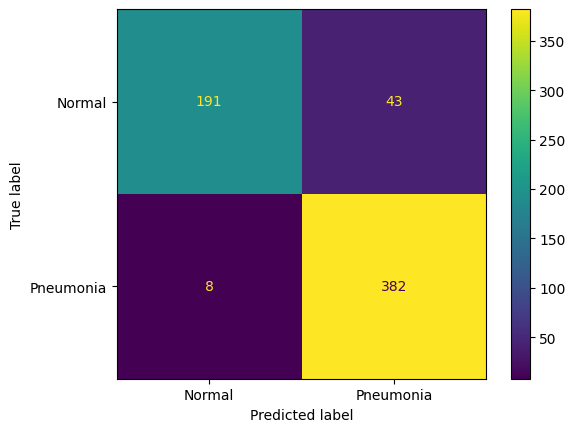

In [13]:
plot_learningcurve(metrics_history_rn18_full)

plot_learningrate(metrics_history_rn18_full['lrs'])

eval_metrics_rn18_full = evaluate_model(model_resnet18_full, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn18_full['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn18_full['precision']:.2f}, Recall: {eval_metrics_rn18_full['recall']:.2f}, F1 score: {eval_metrics_rn18_full['f1']:.2f}, AUC: {eval_metrics_rn18_full['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn18_full['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn18_full['confusion matrix'])

3. ResNet34 model (freeze layers for initialization then finetune by unfreezing last layers)

## 2. ResNet34 model (load pretrained model and allow all layers to be trainable)
For this model, let's start with a pretrained ResNet34 model and allow all layers to be trainable.
### Model setup

In [14]:
model_resnet34 = resnet.get_resnet34(pretrained=True, grayscale=True, freeze=False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weightdecay
optimizer = torch.optim.Adam(model_resnet34.parameters(), lr=learning_rate,weight_decay=1e-5)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,eta_min=1e-6)

# print the model summary
summary(model_resnet34,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

### Train the model

In [15]:
metrics_history_rn34 = train_model(model_resnet34,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [13:28<00:00,  4.96s/it]


  Average train loss:0.139478  
 Accuracy on the train dataset: 94.40%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


  Average val loss:0.316995  
 Accuracy on the validation dataset: 90.54%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [12:21<00:00,  4.55s/it]


  Average train loss:0.077926  
 Accuracy on the train dataset: 97.20%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


  Average val loss:0.301755  
 Accuracy on the validation dataset: 89.42%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [12:18<00:00,  4.53s/it]


  Average train loss:0.054183  
 Accuracy on the train dataset: 97.93%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


  Average val loss:0.186608  
 Accuracy on the validation dataset: 93.43%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [12:25<00:00,  4.57s/it]


  Average train loss:0.047722  
 Accuracy on the train dataset: 98.33%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


  Average val loss:0.181927  
 Accuracy on the validation dataset: 93.27%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [12:24<00:00,  4.57s/it]


  Average train loss:0.041873  
 Accuracy on the train dataset: 98.45%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.223291  
 Accuracy on the validation dataset: 92.15%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [12:40<00:00,  4.67s/it]


  Average train loss:0.024245  
 Accuracy on the train dataset: 99.12%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.354636  
 Accuracy on the validation dataset: 92.15%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [12:20<00:00,  4.54s/it]


  Average train loss:0.020182  
 Accuracy on the train dataset: 99.46%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


  Average val loss:0.148882  
 Accuracy on the validation dataset: 94.55%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [12:19<00:00,  4.54s/it]


  Average train loss:0.015534  
 Accuracy on the train dataset: 99.41%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


  Average val loss:0.220447  
 Accuracy on the validation dataset: 93.27%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [13:03<00:00,  4.81s/it]


  Average train loss:0.012814  
 Accuracy on the train dataset: 99.64%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


  Average val loss:0.242233  
 Accuracy on the validation dataset: 92.47%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [13:15<00:00,  4.88s/it]


  Average train loss:0.009394  
 Accuracy on the train dataset: 99.79%


Validation: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]

  Average val loss:0.203481  
 Accuracy on the validation dataset: 93.27%
Done!


In [16]:
### Save the model

In [17]:
torch.save(model_resnet34,'../models/resnet34_10ep.pth')

### Results

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Validation: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Accuracy on the test set: 93.27%
Precision: 0.91, Recall: 0.99, F1 score: 0.95, AUC: 0.91
classification_report :              precision    recall  f1-score   support

           0       0.98      0.84      0.90       234
           1       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.93       624
weighted avg       0.94      0.93      0.93       624



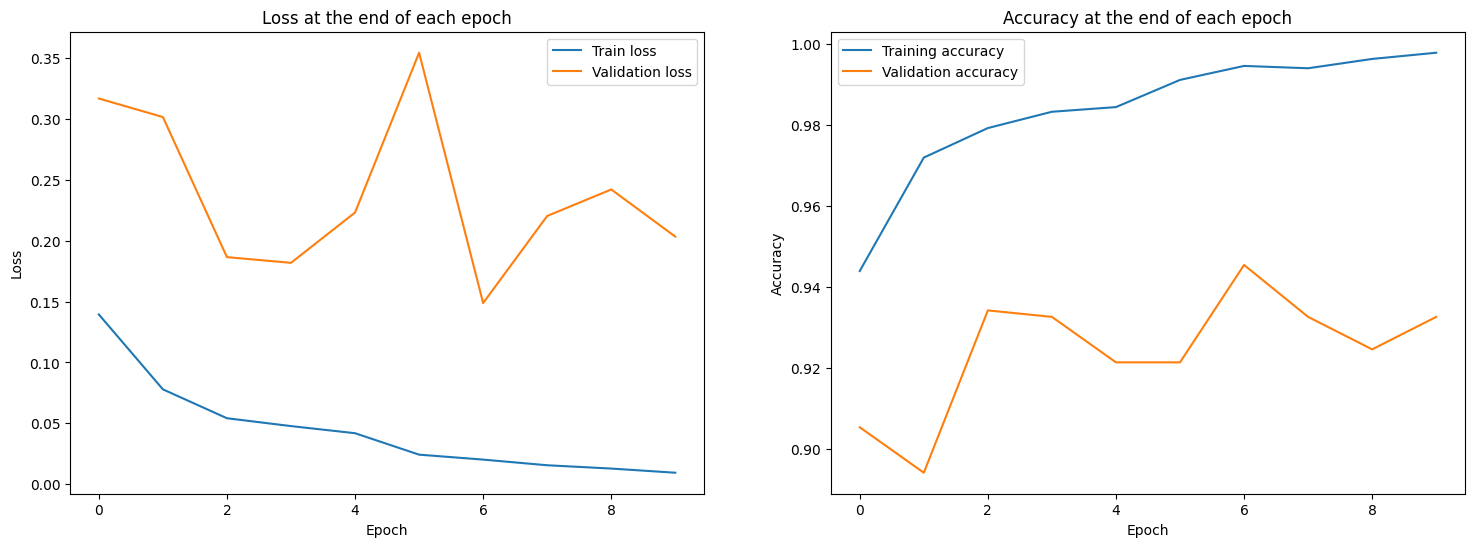

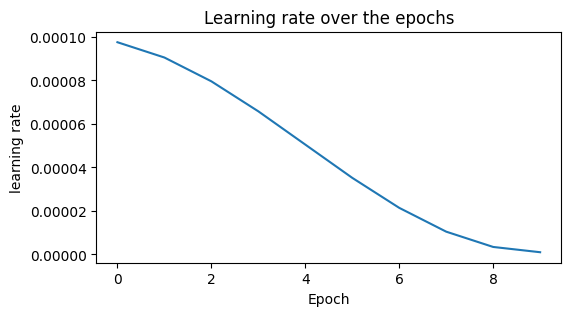

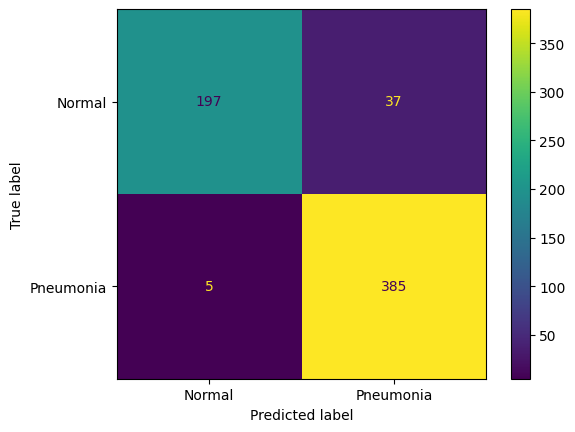

In [18]:
plot_learningcurve(metrics_history_rn34)

plot_learningrate(metrics_history_rn34['lrs'])

eval_metrics_rn34 = evaluate_model(model_resnet34, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn34['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn34['precision']:.2f}, Recall: {eval_metrics_rn34['recall']:.2f}, F1 score: {eval_metrics_rn34['f1']:.2f}, AUC: {eval_metrics_rn34['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn34['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn34['confusion matrix'])